In [1]:
from platform import python_version
print(f'Jupyter Notebook on Mac OS\nPython Version: {python_version()}')

Jupyter Notebook on Mac OS
Python Version: 3.9.12


# D212 - Data Mining II - Clustering Techniques

In [2]:
## Import libraries/packages
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt, warnings
sns.set_palette('colorblind')
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,10)
plt.rcParams['figure.max_open_warning'] = False
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Data Preparation
---

In [3]:
df = pd.read_csv('churn_clean.csv')

In [4]:
## Isolate churn and continuous variables
keep = []
for col in df.columns:
    if df[col].dtype == float:
        keep.append(col)
df = df[keep]

In [5]:
## Drop location columns
df.drop(['Lat', 'Lng',], axis=1, inplace=True)

In [6]:
## Scale the data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [7]:
## Store cleaned data
df.to_csv('clean_dataset.csv')

## Data Analysis
---

In [8]:
## Determine the best value for k
inertia = np.array([])
k_vals = range(1,11)

for k in k_vals:
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(scaled_df)
    inertia = np.append(inertia, kmeans.inertia_)

inertia_vals = pd.DataFrame(inertia, index=k_vals, columns=['Inertia'])

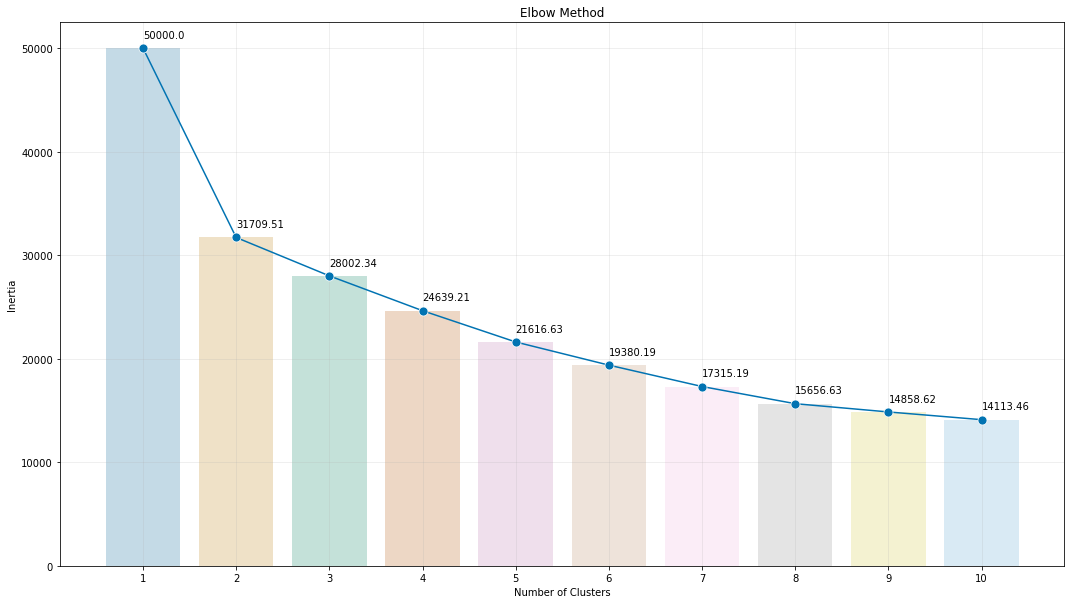

In [9]:
## Plot the inertia values
sns.barplot(x=inertia_vals.index, y=inertia_vals.Inertia, alpha=0.25)
sns.lineplot(x=inertia_vals.index-1, y=inertia_vals.Inertia, marker='o', markersize=9, legend=False)
plt.title('Elbow Method')
plt.xticks(inertia_vals.index-1)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
for i in inertia_vals.index:
    plt.text(
        x=i-1, 
        y=inertia_vals.Inertia[i]+1000, 
        s=round(inertia_vals.Inertia[i], 2)
    )
plt.grid(alpha=0.25)

In [10]:
## Perform kmeans clustering
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=10)
kmeans.fit(scaled_df)

KMeans(n_clusters=2, random_state=10)

In [11]:
## Get the predicted labels
predicted_labels = kmeans.fit_predict(scaled_df)
## Calculate the silhouette score
silhouette = silhouette_score(scaled_df, predicted_labels)
print(f'Silhouette Score: {silhouette}, {n_clusters} clusters')

Silhouette Score: 0.35763272219672476, 2 clusters


In [12]:
## Assign cluster labels
df['Cluster'] = kmeans.labels_ + 1

In [13]:
## Calculate cluster summary
cluster_summary = df.groupby('Cluster').agg(['mean', 'median', 'std']).transpose()
cluster_summary.columns = ['Cluster 1', 'Cluster 2']
cluster_summary

Cluster 1     Cluster 2
Income             mean    39748.262276  39865.614737
                   median  33394.070000  33004.610000
                   std     28030.306465  28371.262961
Outage_sec_perweek mean        9.993424     10.010276
                   median     10.019720     10.017400
                   std         2.978354      2.973956
Tenure             mean        9.133764     59.928772
                   median      7.918063     61.479870
                   std         6.037296      8.476125
MonthlyCharge      mean      172.733981    172.515608
                   median    169.937800    167.456400
                   std        42.868282     43.021817
Bandwidth_GB_Year  mean     1312.287977   5473.227310
                   median   1236.530575   5586.428510
                   std       572.641896    752.111621

In [14]:
## Get centroids
centroids = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_), 
    index=['Cluster 1', 'Cluster 2'], 
    columns=df.columns[:-1]
)

In [15]:
## View centroids
print('Cluster centroids:\n')
for i in centroids.index:
    print(i)
    for col in centroids.columns:
        print(f'{col}: {round(centroids[col][i], 2)}')
    print()

Cluster centroids:

Cluster 1
Income: 39748.26
Outage_sec_perweek: 9.99
Tenure: 9.13
MonthlyCharge: 172.73
Bandwidth_GB_Year: 1312.29

Cluster 2
Income: 39865.61
Outage_sec_perweek: 10.01
Tenure: 59.93
MonthlyCharge: 172.52
Bandwidth_GB_Year: 5473.23



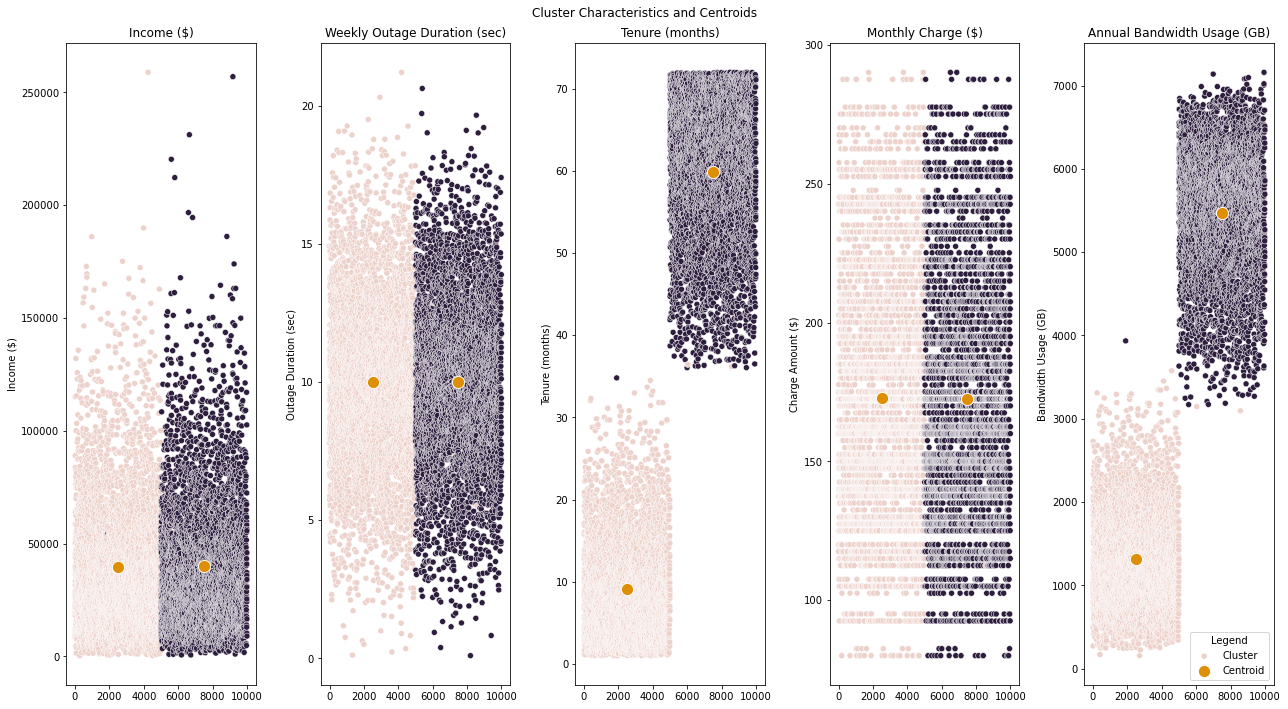

In [16]:
## Plot centroids
centr_x = [sum(df[df.Cluster==1].index)/len(df[df.Cluster==1]), sum(df[df.Cluster==2].index)/len(df[df.Cluster==2])]
titles = [
    'Income ($)', 
    'Weekly Outage Duration (sec)', 
    'Tenure (months)', 
    'Monthly Charge ($)', 
    'Annual Bandwidth Usage (GB)'
]
y_labels = [
    'Income ($)', 
    'Outage Duration (sec)', 
    'Tenure (months)', 
    'Charge Amount ($)', 
    'Bandwidth Usage (GB)'
]
fig,ax = plt.subplots(1,5)
plt.suptitle('Cluster Characteristics and Centroids')
for i in range(5):
    sns.scatterplot(x=df.index, y=df[df.columns[i]], hue=df.Cluster, ax=ax[i], legend=False)
    sns.scatterplot(x=centr_x, y=centroids[centroids.columns[i]], s=150, ax=ax[i])
    ax[i].set_title(titles[i])
    ax[i].set_ylabel(y_labels[i])
ax[4].legend(['Cluster', 'Centroid'], title='Legend', loc='lower right')
plt.tight_layout()